In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import  numpy as np

from time import time
from datetime import timedelta

# importing pacakge 
import sys         
sys.path.append(r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\libraries')        

from main import *
from FinancialData import *
from Chebychev import *

In [3]:
def Random_correlation_matrix(n):
    rho = np.random.uniform(0, 1, (n, n))
    rho = (rho + rho.T) / 2
    np.fill_diagonal(rho, 1)
    rho = np.round(rho, 3)
    return rho

In [4]:
ZCR = ZC_Data_extractor("R:/DR-NATIXIS/ERM/MCRM/LeaderExpert/Stagiaires/2023")
ZC = zero_coupon_bonds(ZCR, 3) # We chose 3 as degree of the Spline Interpolation 

nbr_fx =  2
nbr_swap = 10

portfolio = Multi_FX_irs_portfolio( nbr_fx, nbr_swap, first_date=[0], freq=[0.25, 0.5, 1], Nominal=[10000],
                 maturity=list(np.arange(1, 7 + 0.5, 0.5)),
                 fix_rate=[0.02, 0.05], exercice=['payer'], SEED=1999)

T = portfolio.last_maturity
portfolio.irs_specs

array([(0., 0.25,  50000., 0.04473561, 2.5, 'payer', 1),
       (0., 0.25,  30000., 0.0495388 , 1. , 'payer', 1),
       (0., 0.25,  30000., 0.04679434, 1. , 'payer', 1),
       (0., 0.5 ,  30000., 0.02958941, 7. , 'payer', 1),
       (0., 1.  ,  10000., 0.0377977 , 6.5, 'payer', 0),
       (0., 1.  , 100000., 0.02586477, 4.5, 'payer', 1),
       (0., 1.  ,  10000., 0.0458065 , 2. , 'payer', 0),
       (0., 0.5 ,  10000., 0.04592901, 2. , 'payer', 1),
       (0., 1.  ,  90000., 0.02235853, 6.5, 'payer', 0),
       (0., 0.25,  90000., 0.04150736, 2. , 'payer', 1)],
      dtype=[('first_reset', '<f4'), ('reset_freq', '<f4'), ('notional', '<f4'), ('swap_rate', '<f4'), ('maturity', '<f4'), ('exercice', '<U10'), ('undl', '<i4')])

In [5]:
irs  = portfolio.irs_sub_portfolios[0]
model_params = Model_params(nbr_fx)

cov_matrix = Random_correlation_matrix(2*nbr_fx-1)

In [6]:
diffusion = Multi_FX_Diffusion(0, 7, 3000, [ZC for i in range(nbr_fx)], model_params, 10**4, pb_measure='Risk Neutral',
                 cov_matrix= cov_matrix)
diff = diffusion.extract_mono_diffusion()[0]
diff.get_LGM_params()

(0.014627911, 0.019291218)

In [32]:
t=6.2

## Emukit GPR

In [8]:
mtm_points

NameError: name 'mtm_points' is not defined

(array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]]), array([[1.00016558e-10],
       [1.00016558e-10],
       [1.00016558e-10],
       ...,
       [1.00016558e-10],
       [1.00016558e-10],
       [1.00016558e-10]]))


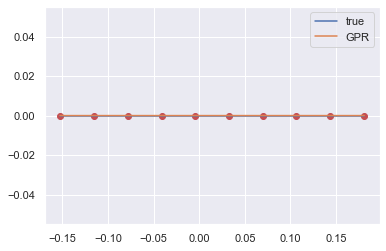

In [33]:
nodes_nbr = 10
train_range = (min(diff.X(t)) , max(diff.X(t)) )

# Pricing to train
train_points = np.linspace(train_range[0], train_range[1], nodes_nbr)
mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())

# Train
gpr_model = BQ(train_points.reshape(nodes_nbr,1), mtm_points.reshape(nodes_nbr,1),train_range[0], train_range[1])

# Mtm Proxy
Mtm = gpr_predictor(gpr_model, np.sort(diff.X(t)).reshape(diffusion.nbr_scenarios,1))
N = 400
x_range = np.linspace(train_range[0], train_range[1], N)
plt.plot(x_range, irs.Mtm_mono(t, x_range,ZC,diff.get_LGM_params()) , label='true')

plt.scatter(train_points,mtm_points,c='r')
plt.plot(np.sort(diff.X(t)) , Mtm[0].reshape(10000) , label='GPR')
#plt.plot(np.sort(diff.X(t)) , Cheb , label='GPR')
plt.legend()
print(Mtm)

## GPy GPR

(array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]),
 array([[6.02379677e-15],
        [6.02379677e-15],
        [6.02379677e-15],
        ...,
        [6.02379677e-15],
        [6.02379677e-15],
        [6.02379677e-15]]))

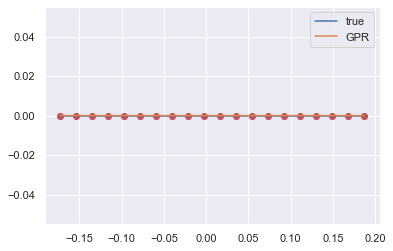

In [26]:
from GPy.models import GPRegression
nodes_nbr = 20
train_range = (min(diff.X(t)) , max(diff.X(t)) )

# Pricing to train
train_points = np.linspace(train_range[0], train_range[1], nodes_nbr)
mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())

# Train
gpr_model = GPRegression(train_points.reshape(nodes_nbr,1), mtm_points.reshape(nodes_nbr,1))
gpr_model.optimize()

# Mtm Proxy
Mtm = gpr_predictor(gpr_model, np.sort(diff.X(t)).reshape(diffusion.nbr_scenarios,1))
N = 400
x_range = np.linspace(train_range[0], train_range[1], N)
plt.plot(x_range, irs.Mtm_mono(t, x_range,ZC,diff.get_LGM_params()) , label='true')

plt.scatter(train_points,mtm_points,c='r')
plt.plot(np.sort(diff.X(t)) , Mtm[0].reshape(10000) , label='GPR')
#plt.plot(np.sort(diff.X(t)) , Cheb , label='GPR')
plt.legend()
Mtm

## Sklearn GPR

In [17]:
X=np.array([1,2,3])
Y=np.array([0,0,2])

In [42]:
irs.print_as_dict()

{'first_reset_date': array([0., 0., 0.], dtype=float32),
 'swap_freq': array([1., 1., 1.], dtype=float32),
 'swap_N': array([10000., 10000., 90000.], dtype=float32),
 'swap_maturity': array([6.5, 2. , 6.5], dtype=float32),
 'swap_fixing_date': array([array([0., 1., 2., 3., 4., 5., 6., 7.]), array([0., 1., 2.]),
        array([0., 1., 2., 3., 4., 5., 6., 7.])], dtype=object),
 'LAST_MATURITY': 6.5,
 'swap_fix_rate': array([0.0377977 , 0.0458065 , 0.02235853], dtype=float32),
 'swap_exercice': array(['payer', 'payer', 'payer'], dtype='<U10'),
 'NBR_SWAPS': 3}

In [45]:
np.arange(0, 6.5, 1)

array([0., 1., 2., 3., 4., 5., 6.])

In [41]:
mtm_points, train_range

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 (-0.1522902240443144, 0.18109218400666502))

In [39]:

t=6.2
nodes_nbr = 15
train_range = (min(diff.X(t)) , max(diff.X(t)) )

# Pricing to train
train_points = np.linspace(train_range[0], train_range[1], nodes_nbr)
mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())

# Train
gpr_model = GaussianProcessRegressor(kernel = kernel, normalize_y=True)
gpr_model.fit(train_points.reshape(nodes_nbr,1), mtm_points.reshape(nodes_nbr,1))


# Mtm Proxy
Mtm = gpr_predictor(gpr_model, np.sort(diff.X(t)).reshape(diffusion.nbr_scenarios,1))
N = 400
x_range = np.linspace(train_range[0], train_range[1], N)
plt.plot(x_range, irs.Mtm_mono(t, x_range,ZC,diff.get_LGM_params()) , label='true')

plt.scatter(train_points,mtm_points,c='r')
plt.plot(np.sort(diff.X(t)) , Mtm.reshape(10000) , label='GPR')
#plt.plot(np.sort(diff.X(t)) , Cheb , label='GPR')
plt.legend()
Mtm




ValueError: array must not contain infs or NaNs

In [ ]:
gpr

## Chebychev 

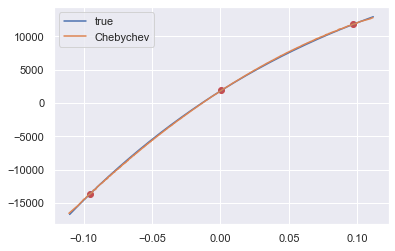

In [12]:
nodes_nbr = 3
train_range = (min(diff.X(t)) , max(diff.X(t)) )

# Pricing to train
train_points = np.sort(Chebyshev_points(train_range[0], train_range[1], nodes_nbr))
mtm_points = irs.Mtm_mono(t,train_points,ZC,diff.get_LGM_params())


# Mtm Proxy
Mtm = np.array([eval_Barycentric(mtm_points, train_points, x) for x in np.sort(diff.X(t))])

N = 400
x_range = np.linspace(train_range[0], train_range[1], N)
plt.plot(x_range, irs.Mtm_mono(t, x_range,ZC,diff.get_LGM_params()) , label='true')

plt.scatter(train_points,mtm_points,c='r')
plt.plot(np.sort(diff.X(t)) , Mtm , label='Chebychev')
#plt.plot(np.sort(diff.X(t)) , Cheb , label='GPR')
plt.legend()

In [ ]:
3

In [ ]:
lb , ub = train_range
bq = BQ(train_points.reshape(nodes_nbr,1),mtm_points.reshape(nodes_nbr,1),lb,ub)

In [ ]:
bq_pred = bq.predict(np.sort(diff.X(t)).reshape(diffusion.nbr_scenarios,1))

In [ ]:
N = 400
x_range = np.linspace(train_range[0], train_range[1], N)
plt.plot(x_range, irs.Mtm_mono(t, x_range,ZC,diff.get_LGM_params()) , label='true')

plt.plot(np.sort(diff.X(t)) , bq_pred[0].reshape(10000) , label='GPR')
plt.legend()

In [ ]:
X , Y = train_points.reshape(nodes_nbr,1), mtm_points.reshape(nodes_nbr,1)

In [ ]:
    model_gpy = GPRegression(X, Y)
    model_gpy.optimize()  #(messages=True, ipython_notebook=True)  # Messages indicates you wish to see the progress of the optimizer, needs ipywidgets to be installed
    # Define the lower and upper bounds of the integral.
#     integral_bounds = [(lb, ub)]
#     # Load core elements for Bayesian quadrature
#     emukit_measure = LebesgueMeasure.from_bounds(integral_bounds)
#     emukit_qrbf = QuadratureRBFLebesgueMeasure(RBFGPy(model_gpy.kern), emukit_measure)
#     emukit_model = BaseGaussianProcessGPy(kern=emukit_qrbf, gpy_model=model_gpy)
#    emukit_method = VanillaBayesianQuadrature(base_gp=emukit_model, X=X, Y=Y)

In [ ]:
N = 400
predictor = model_gpy.predict(np.sort(diff.X(t)).reshape(diffusion.nbr_scenarios,1))
x_range = np.linspace(train_range[0], train_range[1], N)
plt.plot(x_range, irs.Mtm_mono(t, x_range,ZC,diff.get_LGM_params()) , label='true')

plt.plot(np.sort(diff.X(t)) , predictor[0].reshape(10000) , label='GPR')
plt.legend()